# Researching & Developing a Market Neutral Strategy - Case Study

The following notebook aims to demonstrate best practices when developing a market-neutral signal based on Quantopian's data feeds. Following the steps detailed in [this post](https://www.quantopian.com/posts/using-alternative-data-researching-and-implementing-a-market-neutral-strategy) and demonstrated in this notebook will ensure a well-founded alternative data signal that stands a better chance of holding up during out-of-sample validation and live trading.

### Intro - Why use Alternative Data?
Fundamental asset data such as price, volume, or company financials has many benefits including its accessibility and simplicity. However, these advantages are a double-edged sword as any "alpha" left in these datasets can be especially difficult to extract exactly because of the amount of people using the data. 

Because alternative data streams are not as widely available or as easy to use as fundamental ones, finding novel information that has yet to be "priced in" by the market is easier. Further benefits include the tendency for alternative data signals to be uncorrelated to and less noisy than traditional data.

Some of the major drawbacks of alternative data include its lack of structure, cost, exclusivity, and high dimensionality. Luckily, Quantopian takes down some of these barriers through its [wide variety of alternative data feeds](https://www.quantopian.com/data/quandl/currfx_usdeur), many of which are free to use and all of which have been cleaned and standardized to work both in the research environment and in pipeline.

### Abstract

Through some preliminary research we arrive at a hypothesis we would like to test:

** Hypothesis: ** *Equity home bias results in international-domiciled equities being undervalued. US equities with strong inverse correlations to the USD-EUR exchange rate show similarities to these international assets, and because they are US equities and subject to US market biases equity home bias will cause them to be undervalued.*

To test it we:

1) Attempt to measure the presence of equity home bias within the research time period 2009-2010. To do this we compare optimal portfolio positions in US vs. EU equities to what is observed in US investor portfolios over the research period.

2) Try to see if assets with strong negative correlations to the strength of the USD show some similarities to European assets. To do this we compare returns of a strong positive correlation portfolio, strong negative correlation portfolio, and an ETF that tracks top European equities by market cap.

3) Examine if those assets with an inverse relationship to the USD are in fact undervalued. To do this we create an Alphalens factor which longs strong negative correlation equities and shorts strong positive correlation equities and examine its performance over the research period.

We finish by implementing an algorithm based on the [long short equity template](com/lectures/example-long-short-equity-algorithm), running the backtest over the research period and walking forward one year out-of-sample, and analyzing the results using Pyfolio.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import blaze as bz
import math
import numpy as np
import seaborn
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa as tsa

from statsmodels import regression
from odo import odo

# Researching Alternative Data: USD-EUR Exchange Rate
This exchange rate data used in this notebook, as well as the Morningstar fundamental data, are all available as free datafeeds. 

** Initial Hypothesis: ** *The assets in the Q1500US and Q500US universes are all US-based equities and will therefore be affected by the strength of the US dollar. The USD-EUR exchange rate is a good indicator of the strength of the USD and therefore it is worth investigating relationships between the returns of US companies and their correlation with the exchange rate.*

To protect against overfitting, we will conduct our research strictly within the interval 2009-2010, leaving the data for 2011 and after for out-of-sample validation.

In [2]:
# Importing exchange rate data set
# When importing for blaze/non-pipeline research use quantopian.interactive._
# When importing for pipeline use quantopian.pipeline._
from quantopian.interactive.data.quandl import currfx_usdeur

In [3]:
# Exchange rate data is small enough to compute directly into a Pandas DataFrame
data = bz.compute(currfx_usdeur)

# We'll set 'asof_date' as our index, and add a timedelta of 1 day to prevent look ahead bias
# This is because we will not have a good idea about FX data for a specific day until the day after
data = data.set_index(data['asof_date']+pd.Timedelta('1 days')).sort_index().drop('timestamp', 1)
del data['asof_date']

# Renaming columns
data.columns = ['rate', 'high_est', 'low_est']

# Dropping '0' values in the high_est and low_est columns as well as an outlier high_est value of 14
data['high_est'][(data['high_est'] == 0) | (data['high_est'] > 10)] = None
data['low_est'][data['low_est'] == 0] = None

----------- US/Euro Exchange Rate Data -----------
Start:       1999-09-07      End:          2017-07-29
Min Value:   0.627189        Max Value:    1.2064
Avg Value:   0.834315474675  Median Value: 0.791675

Fields: rate high_est low_est
Frequency: daily



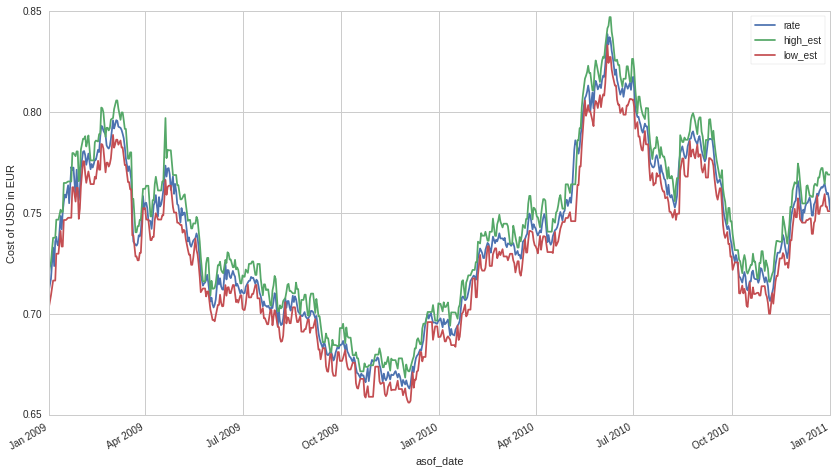

In [4]:
# Getting an understanding of the size and structure of the data by finding 
print "----------- US/Euro Exchange Rate Data -----------"
def summary(data):
    print "%-12s %-15s %-13s %s" % ('Start:', data.index[0].date(), 
                                    'End:', data.index[-1].date())
    print "%-12s %-15s %-13s %s" % ('Min Value:', data.min(), 
                                    'Max Value:', data.max())
    print "%-12s %-15s %-13s %s" % ('Avg Value:', data.mean(), 
                                    'Median Value:', data.median())

summary(data['rate'])

print "\nFields:", data.columns[0], data.columns[1], data.columns[2]
print "Frequency: daily\n"

# Conduct research within this time frame, leaving ample room for out-of-sample-testing
start = '2009-01-01'
end = '2011-01-01'

# Plot rate, high_est, low_est for our window
# Used ffill to fill empty high_est and low_est days with most recent value
data[start:end].ffill().plot();
plt.ylabel('Cost of USD in EUR');

## Macro vs. Asset-Level Data

One important classifier for datasets is whether, for a given point in time, they provide individual values for every asset (such as sentiment, earnings surprises, dividends) or a single macro value (like FX rate, inflation, or gold prices). 

An important concept when dealing with macro data like FX rate is how to apply it to get a unique value for every asset in your universe. The logic you use to decompose a single macro indicator into many asset-level ranking values requires some thought. Some approaches include:

* Correlation/beta coefficient (both will produce same ranking)
* Spearman rank correlation
* Cointegration

After some experimentation with the data, it became apparent that assets with a low correlation of returns to the USD-EUR exchange rate consistently outperformed those with a high one, despite the exchange rate remaining mostly flat over the time period. 

While it may seem tempting to end the process here and put this signal into an algorithm, such a decision would leave you susceptible to overfitting. Without understanding *why* the signal exists means it might as well have come from random chance, and a signal found on random chance alone will probably not hold up during live trading or out-of-sample validation. To learn more about overfitting, refer to the Quantopian [Dangers of Overfitting](https://www.quantopian.com/lectures/the-dangers-of-overfitting) lecture. Researching and understanding an underlying economic hypothesis, a "story" as to why the signal works, will help reduce the risk of overfitting. 

Having a story behind an alpha signal has further benefits beyond reducing overfitting. Should a signal begin to perform poorly, having an economic hypothesis to dissassemble lets you isolate what changed and how to fix it. 

## Equity Home Bias Puzzle
One possible 'story', or explanation, as to why negatively correlated stocks outperform positively correlated ones is the [Equity Home Bias Puzzle](https://en.wikipedia.org/wiki/Equity_home_bias_puzzle). Equity home bias is the tendency for individuals and institutions to hold small amounts of foreign equity investments, despite empirical evidence suggesting "substantial benefits from international diversification." The few possible explanations there are have to do with information immobility and fear of exposure to foreign exchange risk.

It is possible (and we will see if this is true later) that US equities with strong inverse correlations to the USD-EUR exchange can serve as proxies for these international assets because of their inverse relation to the strength of the dollar. If this is the case, because they are US equities and subject to US market biases they will be undervalued.

** Refined Hypothesis: ** *Equity home bias results in international-domiciled equities being undervalued. US equities with strong inverse correlations to the USD-EUR exchange rate might show similarities to these international assets, and because they are US equities and subject to US market biases equity home bias could cause them to be undervalued.*

### Detecting Equity Home Bias

Because our story is based on the presence of this bias it is important to make sure it exists within our test period 2009-2010. We will use some of the methods in [this paper](https://www.aeaweb.org/conference/2015/retrieve.php?pdfid=437) to estimate home bias.$^1$ 

Data on cross-border US portfolio holdings is from the [U.S. Department of the Treasury](https://www.treasury.gov/resource-center/data-chart-center/tic/Pages/fpis.aspx) and US/EU market cap data is from the [World Bank](http://data.worldbank.org/indicator/CM.MKT.LCAP.CD?end=2016&start=1975&view=chart). 

In [5]:
# List of eurozone countries
euro_countries = ['Austria', 'Belgium','Finland','France','Germany',
                 'Greece','Ireland','Italy','Netherlands','Portugal',
                 'Slovakia','Slovenia','Spain','Cyprus','Estonia','Latvia',
                 'Luthuania','Luxembourg','Malta']

# Pull cross-border holdings from U.S. Department of the Treasury
foreign_holdings = local_csv('shchistdat.csv')

# Selecting only investments in eurozone nations and fixing date order
euro_investments = foreign_holdings.loc[foreign_holdings['Unnamed: 1'].isin(euro_countries)][range(2,49,4)]
euro_investments.columns = pd.date_range(end='2015-01-01',periods=12,freq='AS')[::-1]

# Removing thousands separator commas and converting strings of numbers to ints
for column in euro_investments.columns:
    euro_investments[column] = euro_investments[column].str.replace(',','').astype(int)

# Multiply by 1 million because CSV data unit was millions    
euro_investments = euro_investments.sum()*1000000

# Pull country market caps from World Bank
mkt_caps = local_csv('API_CM.MKT.LCAP.CD_DS2_en_csv_v2.csv')

# Select only eurozone and US market caps using country code
mkt_caps = mkt_caps[mkt_caps['Country Code'].isin(['EMU','USA'])]

# Isolating market cap data by country and to within our research range 
USA  = mkt_caps.iloc[1]['2009':'2010']
EMU = mkt_caps.iloc[0]['2009':'2010']

# Finding Euro-USA market cap ratio, Euro-Domestic US investments ratio
# and the difference between the two
mkt_ratio = EMU/USA
holdings_ratio = (euro_investments/(USA-euro_investments))['2009':'2010']
holdings_ratio.index = mkt_ratio.index
diff = mkt_ratio - holdings_ratio

print 'Ratios of Europe-Based Equities to US-Based Equities:\n'

print 'US Investor Average:', holdings_ratio.mean()
print 'CAPM Optimal Ratio:', mkt_ratio.mean()

print '\nDifference:', diff.mean()

Ratios of Europe-Based Equities to US-Based Equities:

US Investor Average: 0.0851800000101
CAPM Optimal Ratio: 0.407509492777

Difference: 0.322329492767


[CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) dictates that the optimal portfolio is one with weights based on the market capitalization of equities within the universe. As such, an optimal international portfolio should have a ratio of US to EU equities equal to the ratio of the size of the total US and EU equity markets.

Across 2009 to 2010, the European equity market cap was 40.7% of the size of the US equity market cap; according to CAPM, any optimal investment portfolio should have similar proportions of US to European equities. 

However, the US Treasury data shows that during our time period US investor portfolios had a Euro-US equity ratio around 8.5%, one-fourth of the optimal amount. This discrepancy is a result of home bias, and this test confirms its presence during the research period.

# Designing a Pipeline

Let's build a [pipeline](https://www.quantopian.com/tutorials/pipeline) to pull in rolling USD-EUR rate correlations for every asset in the Q500US universe. 

In [6]:
# Pipeline API imports
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

# Importing built in factors, universe, and data
from quantopian.pipeline.factors import SimpleMovingAverage, CustomFactor, Returns
from quantopian.pipeline.filters.morningstar import Q1500US, Q500US
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.morningstar import Sector

# Import FX rate and other data
from quantopian.pipeline.data.quandl import currfx_usdeur
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.psychsignal import stocktwits

In [7]:
class FXCorr(CustomFactor):
    """ Custom factor to find correlation of asset returns and FX rate """
    
    inputs = [USEquityPricing.close, currfx_usdeur.rate]
    window_length = 150
    def compute(self, today, asset_ids, out, close, exch_rate):
        # Converting data to returns DataFrame to make correlation calculation faster
        exch_df = pd.DataFrame(np.repeat(exch_rate, len(close[0]), axis = 1)).pct_change(1)
        close_df = pd.DataFrame(close).pct_change(1)
        
        out[:] = exch_df.corrwith(close_df)

class Volatility(CustomFactor):
    """ Custom factor to find volatility """

    inputs = [Returns(window_length=2)]
    window_length = 10

    def compute(self, today, asset_ids, out, returns):

        out[:] = np.std(returns)**2

In [28]:
# Assigning the Q500US as our universe
universe = Q500US()

# Buildling our pipeline
pipe = Pipeline(
    columns={
        'fx_corr' : FXCorr(mask=universe),
    },
    screen=(universe)
)

start = '2009-01-01'
end = '2011-01-01'

# Stores pipeline in result
result = run_pipeline(pipe, start, end)
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = start, end_date = end, fields = 'price')

The distribution of FX correlations across the Q500US:

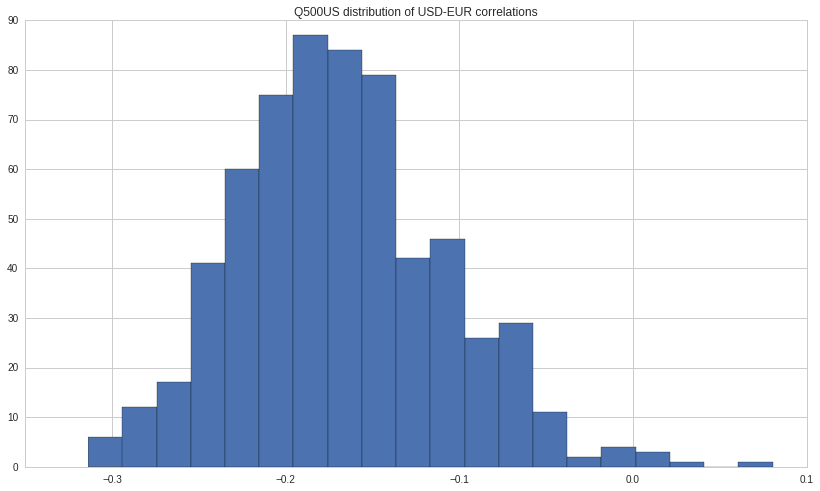

In [29]:
result.unstack()['fx_corr'].mean().hist(bins=20);
plt.title('Q500US distribution of USD-EUR correlations');

## Further Testing our Hypothesis using Pipeline

We know that equity home bias exists within our time period, but we have not explored whether or not US equities with strong inverse correlations to the dollar can be 'proxies' for international markets. If that is the case, they will behave similarly to international assets and will be subject to the same home bias as international assets. 

To see if the assuption that low FX correlation US equities can represent international assets holds, let's compare the returns of the following:

* An ETF that tracks the FTSE Developed Europe All-Cap Index (`VGK`)
* A bucket of 25 stocks with strong negative correlations to FX rate
* A bucket of 25 stocks with strong positive correlations to FX rate

Pipeline made generating rolling correlations to FX rate for each asset easy. Using the pipeline data, lets find correlations of returns between the portfolios:

In [33]:
low_bucket = result.unstack()['fx_corr'].mean().sort_values(ascending=True)[:25].index
high_bucket = result.unstack()['fx_corr'].mean().sort_values(ascending=False)[:25].index

returns = pd.DataFrame()

# Adjusting end date to get a larger timespan to observe the relationships; 
# Still within research period so does not violate integrity of out-of-sample period
adj_end = '2011-01-01'

# Creating equally weighted portfolios of both buckets by first finding pricing using get_pricing
# then using the pct_change() attribute to find returns, and finally averaging across all assets in the bucket
returns['low_bucket'] = get_pricing(low_bucket, start_date=start, end_date=adj_end, 
                                    fields = 'price').pct_change().mean(axis=1,skipna=True)[1:]
returns['high_bucket'] = get_pricing(high_bucket, start_date=start, end_date=adj_end, 
                                     fields = 'price').pct_change().mean(axis=1,skipna=True)[1:]
returns['vgk'] = get_pricing('vgk', start_date=start, end_date=adj_end, fields = 'price').pct_change()[1:]

print 'Correlations of returns:'
print returns.corr()

Correlations of returns:
             low_bucket  high_bucket       vgk
low_bucket     1.000000     0.820017  0.861901
high_bucket    0.820017     1.000000  0.763954
vgk            0.861901     0.763954  1.000000


Within this time period, it seems like the `low_bucket` portfolio is more closely correlated with the Euro index than the `high_bucket` portfolio. For our hypothesis, we will use the `high_bucket` portfolio of US equities to replicate European equities. 

# Analyzing our Factor with Alphalens

Now we will create a new pipeline and run it over 2009-2010 to find factor data for our research period. [Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) will help us evaluate the strength of our `fx_corr` factor within the sample. We will use 1, 10, and 30-day return periods as our factor is based on a long-term relationship between assets and the exchange rate and should therefore be evaluated on a long-term basis.

In [13]:
universe = Q500US()

start = '2009-01-01'
end = '2011-01-01'

pipe = Pipeline(
    columns={
        'fx_corr' : FXCorr(mask=universe)
    },
    screen=(universe)
)

result = run_pipeline(pipe, start, end)
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = start, end_date = end, fields = 'price')

In [14]:
import alphalens as al

# Formats the factor data, pricing data, and group mappings into a DataFrame 
# Necessary for most Alphalens tearsheets
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=-result['fx_corr'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1,10,30))

In [15]:
al.performance.factor_alpha_beta(factor_data)

,1,10,30
Ann. alpha,0.039292,0.028150,0.020030
beta,0.124805,0.142889,0.134844


In [23]:
mean_return_by_q

,1,10,30
factor_quantile,,,
1,-0.000339,-0.003653,-0.011133
2,-0.000193,-0.001113,-0.000391
3,0.000007,0.000219,0.001262
4,0.000172,0.001429,0.002292
5,0.000353,0.003124,0.007995


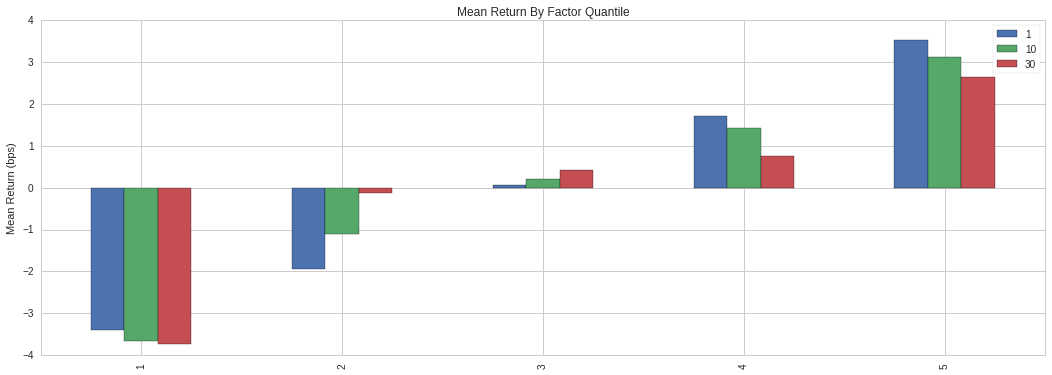

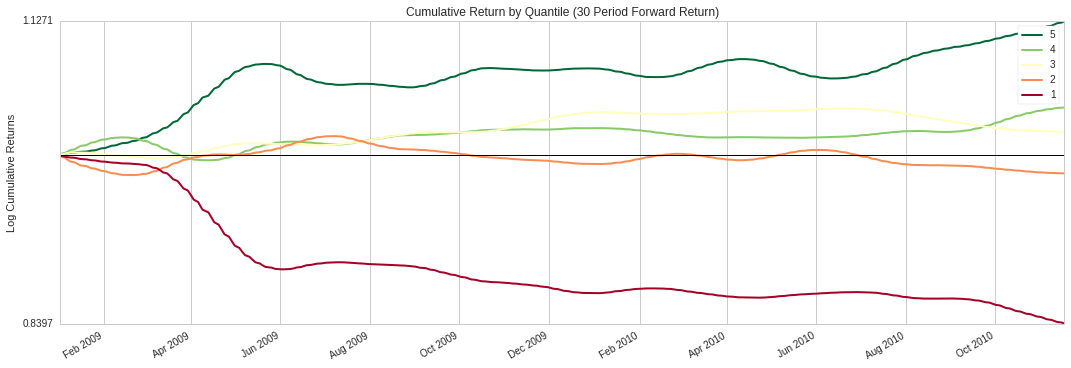

In [35]:
# Use Alphalens to get mean returns by quantile over 1, 10, and 30 day windows
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data, by_group=False)
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data, by_date=True)

al.plotting.plot_quantile_returns_bar(mean_return_by_q.apply(al.utils.rate_of_return, axis=0));
al.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period=30);

For a full Alphalens tearsheet, run the following cell:

In [ ]:
al.tears.create_full_tear_sheet(factor_data)

# Implement and Backtest the Strategy in the IDE
Using the [long-short equity algorithm template](https://www.quantopian.com/lectures/example-long-short-equity-algorithm) makes this step simple. To implement a long-short equity strategy with our `fx_corr` factor, we find the custom factor in the algorithm on line 49 and replace it with `fx_corr`. We can also make any other changes we deem suitable. For this algorithm, lets:

* Comment out the other factors ('value' and 'quality') on lines 100 and 101 as we want to isolate our FX factor 
* Comment out lines 145 and 146, as these lines turn off slippage and commissions but we want their effects included
* Switch from the Q1500US to the Q500US as it was the Q500US we use throughout our research

# Analyze Our Backtest Using Pyfolio
Our in-sample research up until this point was almost entirely contained within the time period 2009-2010. We will run the backtest from 2009-2011, adding in a single year of out-of-sample testing. As a result, the most important part of the below Pyfolio tearsheets will be performance within 2011.

$$
 \
   \overbrace{
    \underbrace{\textit{2009 & 2010}}_\text{In-Sample}\:\:+
    \underbrace{\textit{2011}}_\text{Out-of-Sample}
   }^\text{Backtest}
 \
$$

In [44]:
import pyfolio as pf
from pyfolio import tears
from pyfolio import timeseries
import itertools
import functools

# Get backtest object
bt = get_backtest('5970c1174c2dc64e1c3b1d97')

100% Time: 0:00:03|###########################################################|


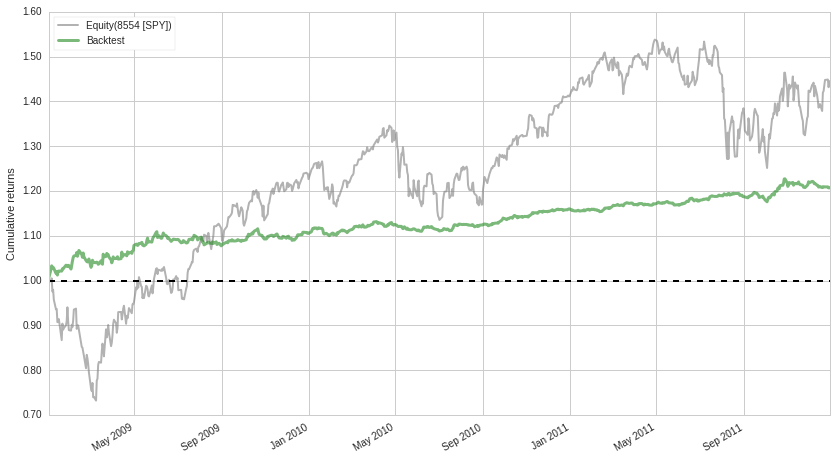

In [45]:
algo_performance = bt.daily_performance
benchmark = get_pricing('SPY', start_date='2009-01-01', end_date='2012-01-01', fields = 'price').pct_change()[1:]
pf.plotting.plot_rolling_returns(algo_performance['returns'], factor_returns=benchmark);

Let's try to find the main drivers of the algorithm's performance. First we can use the Fama-French factor tearsheet from Pyfolio with a 60 day rolling window to measure exposures to the three fundamental factors (market cap, book to price, and momentum). 

CSVs with the returns for these factors can be found [here](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).$^2$

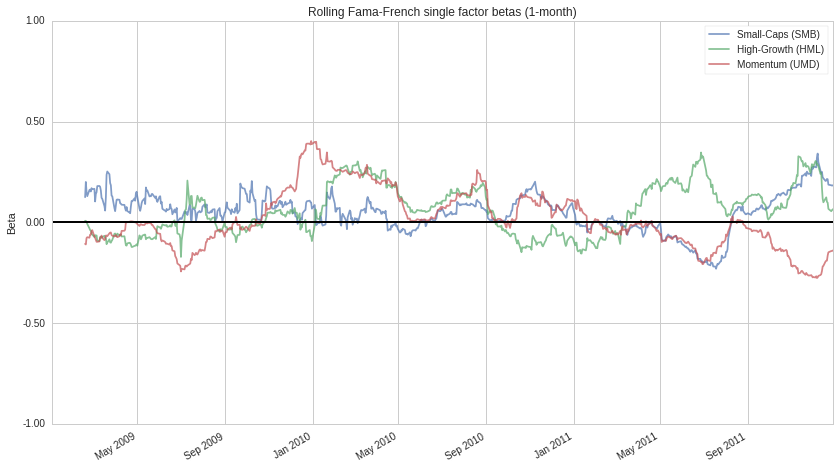

In [46]:
pf.plotting.plot_rolling_fama_french(algo_performance['returns'], rolling_window=30);

Let's try to decompose returns into segments explained by the above factors. This will help us see exactly how much of the algo's returns over the time period are atrributable to exposure to these factors.

Below analysis was inspired by Exhibit 3 in [a report by AQR on Measuring Factor Exposure](https://www.aqr.com/-/media/files/papers/measuring-factor-exposures-uses-and-abuses.pdf).$^3$

In [47]:
def find_vifs(data):
    data = pd.DataFrame(data)
    n = len(data.columns)
    VIFs = np.zeros(n)
    for x in range(n):
        # Calculates VIF using steps described here: 
        # https://en.wikipedia.org/wiki/Variance_inflation_factor#Calculation_and_Analysis
        VIFs[x] = 1/(1-regression.linear_model.OLS(data.ix[:,x], 
        sm.add_constant(np.column_stack((
            [data.ix[:,(x+i+1)%n] for i in range(n-1)] 
        )))).fit().rsquared)      
    return VIFs

def decompose_returns_custom(algo_returns, risk_factors, plot):
    
    # Get excess returns for algo and risk-free rate from Dartmouth using Pyfolio
    risk_free = pf.utils.load_portfolio_risk_factors().loc[algo_returns.index]['RF']
    algo_rets_over_rf = algo_returns - risk_free
    algo_returns_ann = algo_rets_over_rf.mean()*252
    
    # Write index for betas dataframe
    betas_index = ['Alpha','Alpha t-stat']
    for factor in risk_factors.columns.values:
        betas_index = betas_index+[factor]+['{} t-stat'.format(factor)]

    # Create dataframes to store betas and return contributions
    betas = pd.DataFrame(columns = [risk_factors.columns.values],
                                        index = betas_index)
    returns_decomposition = pd.DataFrame(index = itertools.chain(['Alpha'],risk_factors.columns.values),
                                        columns = risk_factors.columns.values)

    # Nested iteration through models and factors in each model
    for factor in risk_factors.columns.values:
        model_factors = sm.add_constant(risk_factors.ix[:,:factor]).loc[algo_rets_over_rf.index]
        model = sm.OLS(algo_rets_over_rf, model_factors).fit()
        for i in range(len(model_factors.columns)):
            beta = model.params[i]
            betas[factor].iloc[2*i] = beta
            betas[factor].iloc[2*i+1] = model.params[i]/model.HC0_se[i]
            if i>0:
                returns_decomposition[factor].iloc[i] = beta*(risk_factors.loc[algo_rets_over_rf.index].mean()*252)[i-1]

    # Annualize alphas
    betas.loc['Alpha'] = betas.loc['Alpha']*252
    returns_decomposition.loc['Alpha'] = betas.loc['Alpha']
    
    # Write column names
    rets_decomp_columns = []
    for i in range(len(risk_factors.columns.values)):
        rets_decomp_columns = rets_decomp_columns + ['Model {}: Add {}'.format(i, risk_factors.columns.values[i])]
    returns_decomposition.columns = rets_decomp_columns
    
    # Finds variance inflation factors using function defined above
    VIFs = find_vifs(risk_factors)
    
    # Plotting conditional on input
    if plot:
        
        # Create bar graph, with horizontal lines at 0 and annualized algo returns
        ax = returns_decomposition.T.plot(kind='bar', stacked=True, rot=-30)
        ax.plot(ax.get_xlim(),[algo_returns_ann]*len(ax.get_xlim()), linestyle = '--', color='black', label = 'Algo Returns');
        ax.plot(ax.get_xlim(),[0]*len(ax.get_xlim()), color='black');
        ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5));
        
        # Fill in green and red zones to represent positive and negative return contributions
        ylim = ax.get_ylim()
        ax.fill_between(ax.get_xlim(), 0, ylim[0], facecolor='red', alpha = 0.1)
        ax.fill_between(ax.get_xlim(), ylim[1], 0, color='green', alpha = 0.1)
        plt.ylim(ylim)
        
        plt.ylabel('Excess Returns');
        plt.title('Excess Returns Decomposition')

    return betas, returns_decomposition, risk_factors.mean()*252, algo_returns_ann, VIFs

def decompose_returns(algo_returns, plot):
    
    # Loads Fama-French risk factors from Dartmouth using Pyfolio
    risk_factors = pf.utils.load_portfolio_risk_factors().loc[algo_returns.index]
    del risk_factors['RF']
    return decompose_returns_custom(algo_returns, risk_factors, plot)

Variance Inflation Factors:
[ 2.16028473  1.34813857  2.22835361  1.60996824]

Betas:                   Mkt-RF        SMB         HML     Mom   
Alpha          0.0537356  0.0528727   0.0432647  0.0275121
Alpha t-stat     2.01595    2.00192      1.7057    1.15618
Mkt-RF          0.055417  0.0495098    0.094671  0.0838148
Mkt-RF t-stat    5.87536    4.41303     6.64337    7.33696
SMB                  NaN  0.0346142 -0.00432747  0.0203095
SMB t-stat           NaN    1.54278   -0.205814    1.03043
HML                  NaN        NaN   -0.106863  -0.171577
HML t-stat           NaN        NaN    -4.33332   -6.03916
Mom                  NaN        NaN         NaN -0.0852706
Mom    t-stat        NaN        NaN         NaN   -5.31589

Factor Excess Returns:
Mkt-RF    0.165067
SMB       0.053100
HML      -0.039500
Mom      -0.160433
dtype: float64


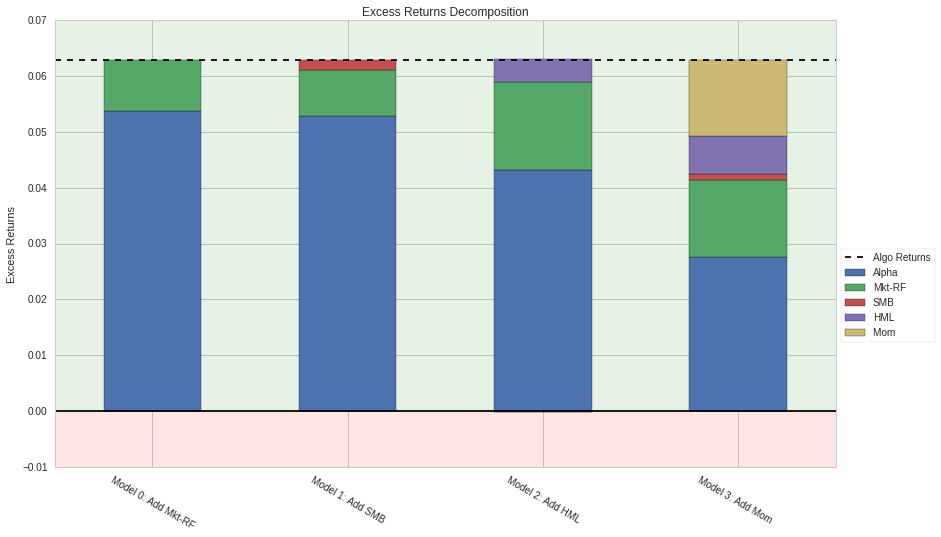

In [48]:
algo_returns = algo_performance['returns']
decomposition = decompose_returns(algo_returns, plot=True)

print 'Variance Inflation Factors:\n', decomposition[4]
print '\nBetas:', decomposition[0]
print '\nFactor Excess Returns:\n', decomposition[2]

The VIFs are all under 5 meaning multicollinearity is too small to warrant exclusion of any risk factor based on correlation with each other. Despite this, the breakdown of algo returns will be somewhat volatile so it is best to look at it across the entire sample like above as opposed to on a rolling basis. 

One of these factors, momentum, seems to explain much of the algorithim's performance within the fourth model. This is due to the algo having a significant negative exposure (tstat = -5.3) and the momentum factor having negative returns over the time period (-16%). Let's look at a couple others factors to see if they help explain some more of the returns. The ones we will investigate are:

* Volatility
* Short-term mean reversion

We can generate returns for these factors on our own:

In [49]:
class Vol_3M(CustomFactor):
        ''' Volatility Factor'''
        inputs = [Returns(window_length=2)]
        window_length = 60
        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
class ST_MR(CustomFactor):
        '''Short-term Mean Reversion Factor'''
        inputs = [USEquityPricing.close]
        window_length = 5

        def compute(self, today, assets, out, price):
            out[:] = np.mean(price[-5:-1])/price[0]     

universe = Q500US()

pipe = Pipeline(
    columns={
        'VOL' : Vol_3M(mask=universe),
        'STMR' : ST_MR(mask=universe)
    },
    screen=(universe)
)

start = '2009-01-01'
end = '2012-01-01'

alt_result = run_pipeline(pipe, start, end)

In [50]:
assets = alt_result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = start, end_date = end, fields = 'price')

# Using Alphalens to get DataFrame with factor data
VOL_factor_data = al.utils.get_clean_factor_and_forward_returns(factor=alt_result['VOL'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1, 5))
STMR_factor_data = al.utils.get_clean_factor_and_forward_returns(factor=alt_result['STMR'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1,5))

,Mkt-RF,SMB,HML,Mom,VOL,STMR
Alpha,0.0537356,0.0528727,0.0432647,0.0275121,0.0271602,0.0295876
Alpha t-stat,2.01595,2.00192,1.7057,1.15618,1.14432,1.23905
Mkt-RF,0.055417,0.0495098,0.094671,0.0838148,0.0837645,0.0834903
Mkt-RF t-stat,5.87536,4.41303,6.64337,7.33696,7.3108,7.3148
SMB,NaN,0.0346142,-0.00432747,0.0203095,0.0204046,0.0214652
SMB t-stat,NaN,1.54278,-0.205814,1.03043,1.03572,1.0861
HML,NaN,NaN,-0.106863,-0.171577,-0.171465,-0.168513
HML t-stat,NaN,NaN,-4.33332,-6.03916,-6.02161,-5.91933
Mom,NaN,NaN,NaN,-0.0852706,-0.0854911,-0.0875817
Mom t-stat,NaN,NaN,NaN,-5.31589,-5.28629,-5.45745


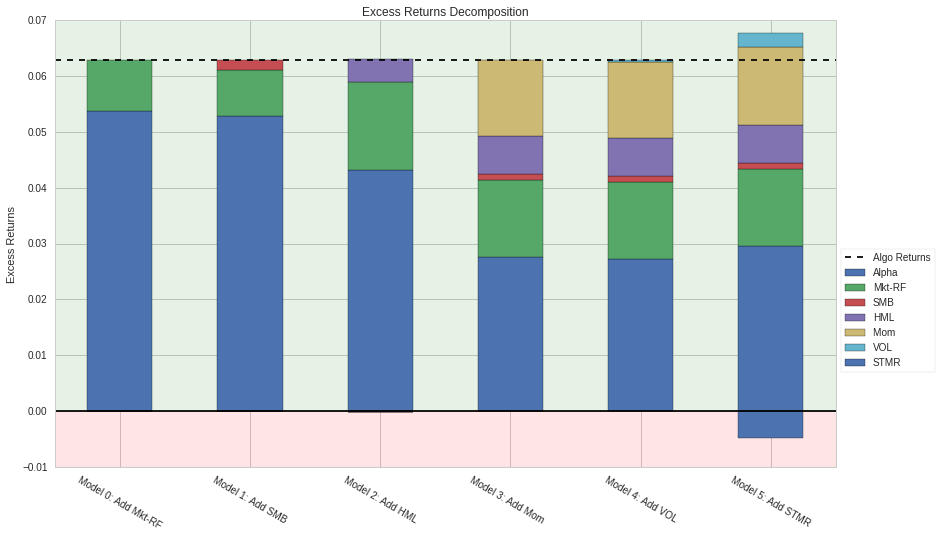

In [53]:
# Using Alphalens to get factor returns
VOL_rets = al.performance.factor_returns(VOL_factor_data)[1]
STMR_rets = al.performance.factor_returns(STMR_factor_data)[1]
alt_factors = pd.DataFrame([VOL_rets, STMR_rets], index=['VOL','STMR']).T

risk_factors = pf.utils.load_portfolio_risk_factors()
del risk_factors['RF']

new_risk_factors = pd.concat([risk_factors, alt_factors], axis=1, join_axes=[algo_returns.index]).ffill()

decompose_returns_custom(algo_returns, new_risk_factors, plot=True)[0]

Of the new factors, none compose more of our algo's returns than momentum.

For a full Pyfolio tearsheet, run the following cell:

In [13]:
# Create full tear sheets 
bt.create_full_tear_sheet()

## Decay of US-Europe Equity Home Bias
Although our factor performed well in the above out-of-sample testing, further out-of-sample testing shows that it begins to falter after 2013. A possible reason for this is the decline of equity home bias as our factor is dependent on US investor aversion to international diversification. Let's use the home bias calculations from our research stage earlier on in the notebook, and expand them to encompass 2004-2015:

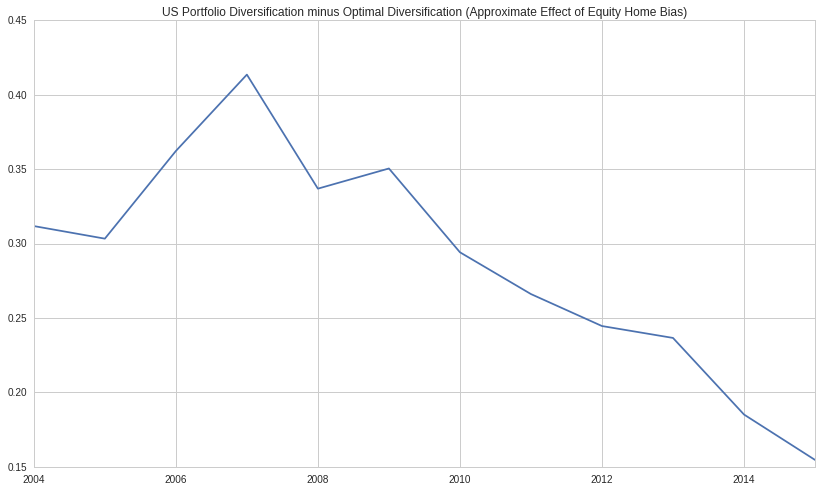

In [9]:
# Isolating market cap data by country and to within our research range 
USA  = mkt_caps.iloc[1]['2004':'2015']
EMU = mkt_caps.iloc[0]['2004':'2015']

# Finding Euro-USA market cap ratio, Euro-Domesting US investments ratio
# and the difference between the two
mkt_ratio = EMU/USA
holdings_ratio = euro_investments/(USA-euro_investments)
holdings_ratio.index = mkt_ratio.index
diff = mkt_ratio - holdings_ratio

# Plotting
diff.plot();
plt.title('US Portfolio Diversification minus Optimal Diversification (Approximate Effect of Equity Home Bias)');

With the exception of peaks right before and after the recession, equity home bias between the US and Europe has been in constant decline and with developments in globalization, trade, and communications it is expected to continue on this downwards trend. Based on this we can maybe expect our factor to perform worse in the future as equity home bias fades away, although in some ways it is dependent on home bias decreasing as well. Without home bias decreasing, those undervalued foreign assets will remain undervalued; it is only through the general decline of home bias that those undervalued assets will approach an efficient price which we need to happen if our algo is to see returns from investing in undervalued assets.

### Possible Next Steps

* Explore biases for other foreign markets given that US-Europe home bias is declining. Although the only exchange rate offered as a data feed is the USD-EUR exchange rate, Quantopian offers currency futures data which could be used to a similar end as the FX rate was in this notebook
* Find a daily or monthly measure of US-Europe equity home bias and put it into a factor model to see if it composes much of our algos returns
* Aggregate this factor with uncorrelated alpha factors
* Hedge negative exposure to momentum
* Adjust algo parameters like `MAX_GROSS_LEVERAGE`, `NUM_LONG_POSITIONS`, and `NUM_SHORT_POSITIONS`
* Further out-of-sample validation

### References
Rob Reider, Jamie McCorriston, and Max Margenot

$^1$Wynter, Matthew M. "Why Has the U.S. Foreign Portfolio Share Increased?" SSRN Electronic Journal, March 2014, 6-7. Accessed July 19, 2017. doi:10.2139/ssrn.2679196.

$^2$French, Kenneth R. Factor Returns. May 31, 2017. Raw data. Dartmouth College, Hanover, NH.

$^3$Israel, Ronen, and Ross Adrienne. "Measuring Factor Exposures: Uses and Abuses." SSRN Electronic Journal, October 2015, 4-5. doi:10.2139/ssrn.2841037.


*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*